C:\Users\82104\AppData\Local\Temp\ipykernel_29060\2825782533.py:8: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("general_customers_all.csv")



[이탈 위험 점수(Churn Score) 상위 10명]
         발급회원번호    Slope_Spend  Slope_Balance  Churn_Score
45831  SYN_6996 -259949.057143  -4.660814e+05         65.5
42058  SYN_2794 -252282.000000  -1.153060e+05         59.9
44523  SYN_5559 -269313.542857  -4.408969e+04         45.9
43107  SYN_3956 -222279.228571  -1.688151e+05         42.1
44425  SYN_5455 -223850.714286  -6.172100e+04         41.3
47866  SYN_9236  -60932.800000  -1.319902e+06         37.9
47974  SYN_9371  -66425.457143  -7.836350e+05         37.4
42952  SYN_3788 -100427.771429  -8.815257e+05         37.0
46630  SYN_7870 -185475.057143  -3.622340e+04         36.7
45174  SYN_6254 -155607.628571  -2.336961e+05         36.5

[클러스터별 평균 특성 확인]
            Churn_Score   Slope_Spend
Cluster_ID                           
0              8.407987 -26173.650059
1              1.333526   2824.063640
2             20.873684 -95044.873899


C:\Users\82104\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82104\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53448 (\N{HANGUL SYLLABLE TAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82104\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82104\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\82104\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49548

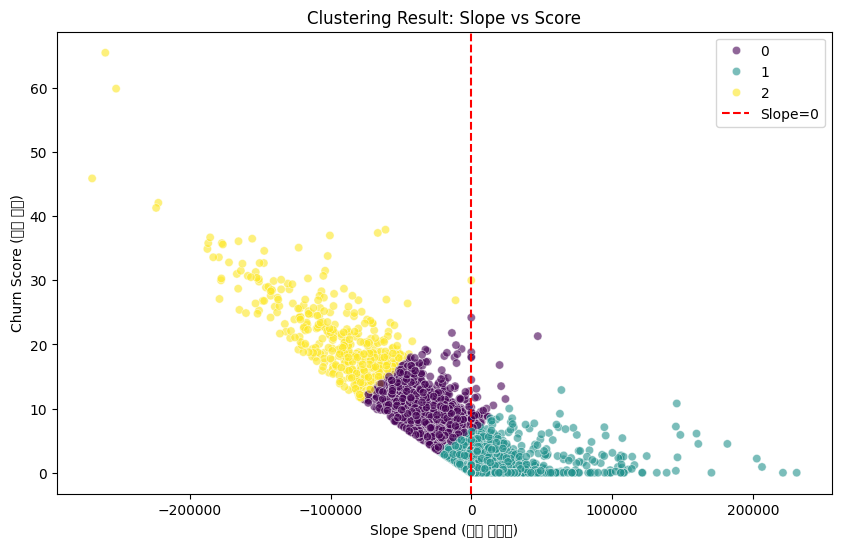

------------------------------
[클러스터별 분포 현황]
            인원수(명)  비율(%)
Cluster_ID               
0             1803  22.29
1             5888  72.78
2              399   4.93
------------------------------
▶ [Cluster 0] 위험군 비율: 22.29%
▶ [Cluster 0] 인원수: 1,803명


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler



df = pd.read_csv("general_customers_all.csv")

# df = df.sort_values(by=['발급회원번호', '기준년월'])

# -------------------------------------------------------
# 1. 6개월 기울기(Slope) 계산 (df에 바로 생성)
# -------------------------------------------------------
def calc_slope_6m(series):
    if len(series) < 2 or np.sum(series) == 0: return 0
    y = series.values
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return slope

# transform으로 전체 데이터에 기울기 적용
df['Slope_Spend'] = df.groupby('발급회원번호')['이용금액_신용_B0M'].transform(calc_slope_6m)
df['Slope_Balance'] = df.groupby('발급회원번호')['잔액_B0M'].transform(calc_slope_6m)
df['Slope_Count'] = df.groupby('발급회원번호')['이용건수_신용_B0M'].transform(calc_slope_6m)

# -------------------------------------------------------
# 2. 현재 시점(12월) 데이터만 추출
# -------------------------------------------------------
target_month = df['기준년월'].max()
df_final = df[df['기준년월'] == target_month].copy()

# -------------------------------------------------------
# 3. [핵심] 기울기를 '이탈 점수'로 변환 (Normalization)
# -------------------------------------------------------
# 전략: 기울기가 음수일수록(가파른 감소) 높은 점수를 줍니다.
# 양수(증가)인 경우는 이탈 위험이 없으므로 0점으로 처리합니다.

scaler = MinMaxScaler()

def convert_slope_to_score(col_name):
    negative_slopes = df_final[col_name].apply(lambda x: -x if x < 0 else 0)
    return scaler.fit_transform(negative_slopes.values.reshape(-1, 1)).flatten()

# 각 지표별 '감소 심각도' (0.0 ~ 1.0)
score_spend_norm = convert_slope_to_score('Slope_Spend')
score_balance_norm = convert_slope_to_score('Slope_Balance')
score_count_norm = convert_slope_to_score('Slope_Count')

# -------------------------------------------------------
# 4. 가중치 적용 및 최종 점수 산출 (100점 만점)s

has_risk = np.where(
    (df_final.get('연체잔액_B0M', 0) > 0) |
    (df_final.get('승인거절건수_B0M', 0) > 0),
    1, 0
)

df_final['Churn_Score'] = (
    (score_spend_norm * W_SPEND) +
    (score_balance_norm * W_BALANCE) +
    (score_count_norm * W_COUNT) +
    (has_risk * W_RISK)
)

df_final['Churn_Score'] = df_final['Churn_Score'].round(1)

print("\n[이탈 위험 점수(Churn Score) 상위 10명]")
cols_view = ['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Churn_Score']
print(df_final[cols_view].sort_values('Churn_Score', ascending=False).head(10))


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. 클러스터링에 사용할 핵심 변수 선택
cluster_cols = ['Churn_Score', 'Slope_Spend']

# 데이터 준비
X_cluster = df_final[cluster_cols].copy()

# 2. 스케일링 (필수)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# 3. K-Means 클러스터링 (K=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 원본 데이터에 클러스터 라벨 붙이기
df_final['Cluster_ID'] = clusters

# -------------------------------------------------------
# 4. 결과 해석 (통계)
# -------------------------------------------------------
print("\n[클러스터별 평균 특성 확인]")
print(df_final.groupby('Cluster_ID')[cluster_cols].mean())

# -------------------------------------------------------
# 5. 시각화
# -------------------------------------------------------
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=df_final,
    x='Slope_Spend',
    y='Churn_Score',
    hue='Cluster_ID',
    palette='viridis',
    alpha=0.6
)

plt.title('Clustering Result: Slope vs Score')
plt.xlabel('Slope Spend (소비 기울기)')
plt.ylabel('Churn Score (이탈 점수)')

plt.axvline(x=0, color='r', linestyle='--', label='Slope=0')
plt.legend()
plt.show()

# -------------------------------------------------------
# 6. 클러스터 분포 확인
# -------------------------------------------------------
cluster_counts = df_final['Cluster_ID'].value_counts().sort_index()
cluster_ratios = df_final['Cluster_ID'].value_counts(normalize=True).sort_index() * 100

print("-" * 30)
print("[클러스터별 분포 현황]")
df_summary = pd.DataFrame({
    '인원수(명)': cluster_counts,
    '비율(%)': cluster_ratios.round(2)
})
print(df_summary)
print("-" * 30)

target_group = 0
print(f"▶ [Cluster {target_group}] 위험군 비율: {cluster_ratios[target_group]:.2f}%")
print(f"▶ [Cluster {target_group}] 인원수: {cluster_counts[target_group]:,}명")


In [1]:
import pandas as pd

df = pd.read_csv("general_customers_all.csv")
df.head()


import numpy as np
import shap
import xgboost as xgb
from statsmodels.stats.outliers_influence import variance_inflation_factor

df = df.head(2000)
print(f"데이터 2,000개 로딩 완료! (남은 행 개수: {len(df)}개)")

# ✅ Target 없으면 자동으로 만들어줌(에러 방지용)
# 1) Cluster_ID + Churn_Score 있으면: Churn_Score 평균이 가장 높은 클러스터를 위험군(Target=1)으로 지정
# 2) 없으면 이용금액대가 있으면: '미사용' 포함이면 Target=1
if "Target" not in df.columns:
    if ("Cluster_ID" in df.columns) and ("Churn_Score" in df.columns):
        risk_cluster = df.groupby("Cluster_ID")["Churn_Score"].mean().idxmax()
        df["Target"] = (df["Cluster_ID"] == risk_cluster).astype(int)
    elif "이용금액대" in df.columns:
        df["Target"] = df["이용금액대"].astype(str).str.contains("미사용").astype(int)
    else:
        raise ValueError("❌ Target 컬럼이 없고, Target을 만들 기준(Cluster_ID+Churn_Score 또는 이용금액대)도 없음.")

# 2. 분석용 데이터 만들기 (X, y 분리)
drop_cols = ['Target', 'Cluster_ID', 'Churn_Score', '발급회원번호', '기준년월']
existing_drop = [c for c in drop_cols if c in df.columns]

X = df.drop(columns=existing_drop).select_dtypes(include=[np.number])
X = X.fillna(0)

y = pd.to_numeric(df['Target'], errors="coerce").fillna(0).astype(int)

if y.nunique() < 2:
    raise ValueError(f"❌ Target이 한 가지 값만 있음(0/1 둘 다 있어야 학습 가능). 분포: {y.value_counts().to_dict()}")

if X.shape[1] == 0:
    raise ValueError("❌ 숫자형 변수(X)가 0개임. 데이터 컬럼 타입 확인 필요.")

print(f"분석할 변수 개수: {len(X.columns)}개")


print("1/3. SHAP 중요도 먼저 계산 중...")

model = xgb.XGBClassifier(
    n_estimators=100,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

if isinstance(shap_values, list):
    shap_importance = np.abs(shap_values[1]).mean(axis=0)
else:
    shap_importance = np.abs(shap_values).mean(axis=0)

shap_df = pd.DataFrame({
    "Feature": X.columns,
    "SHAP_Importance": shap_importance
})

print("SHAP 계산 끝!")

print("2/3. VIF (다중공선성) 계산 중...")

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns

vif_scores = []
for i in range(X.shape[1]):
    try:
        score = variance_inflation_factor(X.values, i)
    except:
        score = np.inf
    vif_scores.append(score)

vif_data["VIF_Score"] = vif_scores

print("VIF 계산 끝!")

print("3/3. 결과 합치고 저장 중...")

final_result = pd.merge(shap_df, vif_data, on="Feature", how="left")
final_result = final_result.sort_values(by="SHAP_Importance", ascending=False)

print("\n[가장 중요한 변수 TOP 10]")
print(final_result.head(10))

save_name = "General_Feature_Analysis_SHAP_VIF_2000.csv"
final_result.to_csv(save_name, index=False, encoding='utf-8-sig')

print(f"\n🎉 저장 완료! '{save_name}' 파일을 열어봐. 가장 중요한 변수가 맨 위에 있을 거야!")


C:\Users\82104\AppData\Local\Temp\ipykernel_26256\272115080.py:3: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("general_customers_all.csv")
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


데이터 2,000개 로딩 완료! (남은 행 개수: 2000개)
분석할 변수 개수: 789개
1/3. SHAP 중요도 먼저 계산 중...


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:51:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


SHAP 계산 끝!
2/3. VIF (다중공선성) 계산 중...


c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\82104\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


VIF 계산 끝!
3/3. 결과 합치고 저장 중...

[가장 중요한 변수 TOP 10]
                Feature  SHAP_Importance     VIF_Score
174        이용개월수_신용_R3M         4.024390  1.830873e+03
442  연속무실적개월수_기본_24M_카드         0.649507  9.121836e+00
752          이용카드수_신용체크         0.563809  1.501200e+15
154         이용건수_신용_R3M         0.544724           inf
64          이용금액_신용_B0M         0.361465           inf
144        이용개월수_신용_R6M         0.300355  1.498607e+03
762          _1순위카드이용금액         0.183718  4.052471e+02
114       이용개월수_신용_R12M         0.103182  6.092934e+02
165         이용금액_신판_R3M         0.070156           inf
433          연체입금원금_B2M         0.066832           inf

🎉 저장 완료! 'General_Feature_Analysis_SHAP_VIF_2000.csv' 파일을 열어봐. 가장 중요한 변수가 맨 위에 있을 거야!
